In [5]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import sys


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'ray_tracing_synthesis')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
torch.use_deterministic_algorithms(True)
import matplotlib.pyplot as plt
from model import build_net

from utils import remove_blind_region_psf0, remove_blind_region_psf7p5, remove_blind_region_minuspsf7p5
import pytorch_SSIM_module

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import random
import time
from time import sleep
from PIL import Image

from ray_tracing_synthesis import SoSToTimeShiftTransformer, image_to_sos_map

PARAM_SOS_BEAMFORMING = 1540
PARAM_SCALING_INPUT = 100000000
PARAM_SCALING_OUTPUT = 100
PARAM_BASE_OUTPUT = PARAM_SOS_BEAMFORMING
PARAM_NUMBER_OF_TRAINING_DATA = 1280000
PARAM_LEARNING_RATE = 0.0005
PARAM_WEIGHTDECAY = 0.3
EPOCH_NUM = 3
BATCH_SIZE = 32
GPU_BASE = 4
GPU_LIST_TO_PARALLEL = [GPU_BASE, 1,2,3] ### Specify the available GPU indices in your machine 
STARTING_PIXEL = 19
WIDTH_IN_PIXEL = 50

from worker_module import preparing_training_data  


data_parent_dir = './untar_ImageNet_6_1/'

def eval_testingdata(model, test_data, test_label, criterion):
    outputs = (
        model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
        [:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL] * PARAM_SCALING_OUTPUT
        + PARAM_BASE_OUTPUT
    )
    loss = criterion(outputs, test_label.to(f"cuda:{GPU_BASE}", dtype=torch.float))
    print("RMSE in testing set is", torch.sqrt(loss.cpu()).detach().numpy())

import multiprocessing as mp
mp.set_start_method("spawn", force=True)

# Prepare test data
transformer = SoSToTimeShiftTransformer()
sos_from_ImageNet = []
time_lag_from_ImageNet = []
for i in range(PARAM_NUMBER_OF_TRAINING_DATA+1, PARAM_NUMBER_OF_TRAINING_DATA+201):
    image = Image.open(f"{data_parent_dir}grayscale_cropped_{i}.JPEG")
    sos_map = image_to_sos_map(image)
    time_lag_from_ImageNet.append([
        remove_blind_region_psf7p5(transformer.transform(sos_map, "7p5psf")),
        remove_blind_region_psf0(transformer.transform(sos_map, "0psf")),
        remove_blind_region_minuspsf7p5(transformer.transform(sos_map, "minus7p5psf")),
    ])
    sos_from_ImageNet.append(sos_map[:, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL])

test_data = torch.tensor(np.array(time_lag_from_ImageNet))
test_label = torch.tensor(np.array(sos_from_ImageNet)).unsqueeze(1)
del sos_from_ImageNet, time_lag_from_ImageNet


Class initializing, device is cuda


In [6]:
def visualize_test_data():
    fig, axs = plt.subplots(2, 6, figsize=(16, 6))
    outputs_test = (
            model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
            [:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL] * PARAM_SCALING_OUTPUT
            + PARAM_BASE_OUTPUT
        ).cpu().detach().numpy()

    for i in range(2):
        for j in range(6):
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + (i * 4 + j))
            if i == 0:
                im = axs[i, j].imshow(test_label[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Ground Truth")
            if i == 1:
                im = axs[i, j].imshow(outputs_test[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Reconstructed")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            cbar = fig.colorbar(im, ax=axs[i, j])
            cbar.set_label("SoS [m/s]",fontsize = 13)

    plt.tight_layout()
    plt.show()

Elapsed time = 17.439136743545532
batch 1 / 40000
running_loss = 5444.95458984375
batch_loss = 4250.630859375
queue length = 3176
RMSE in testing set is 61.35021


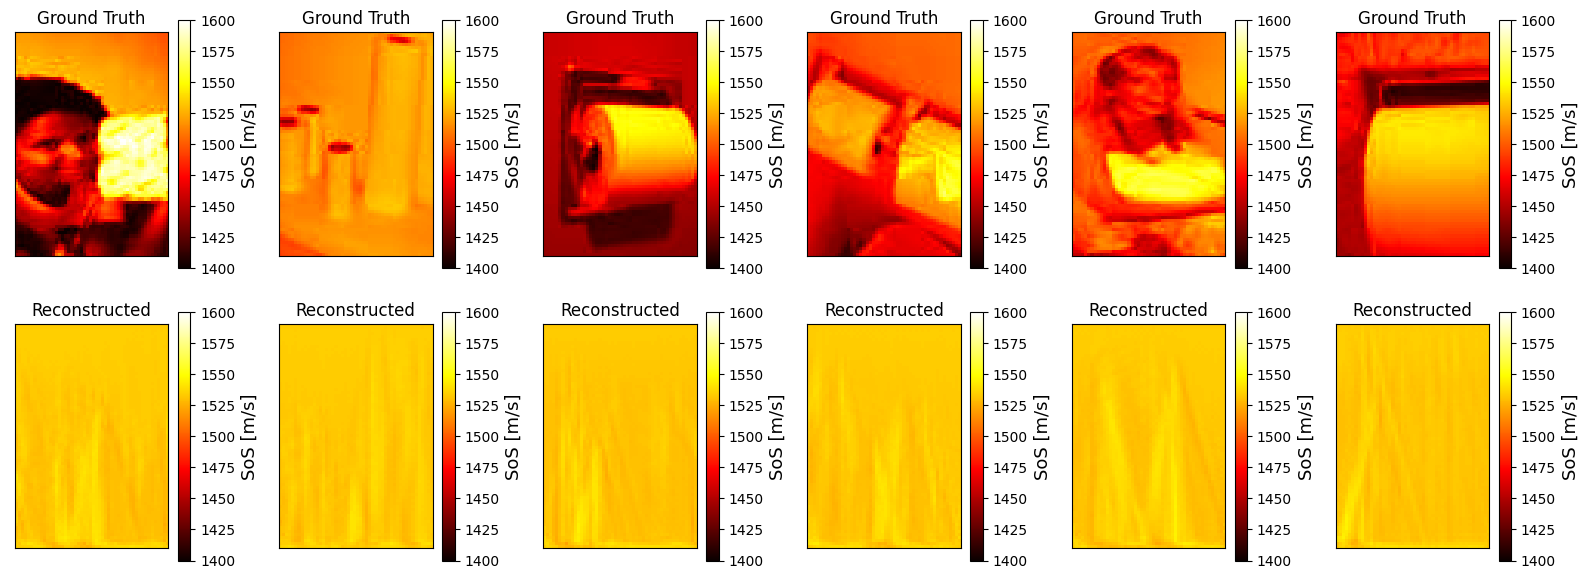

Elapsed time = 88.87800216674805
batch 1001 / 40000
running_loss = 1338.5269174176062
batch_loss = 1008.3284912109375
queue length = 126
RMSE in testing set is 26.634464
Elapsed time = 97.66375946998596
batch 2001 / 40000
running_loss = 1126.6462025828175
batch_loss = 775.2987670898438
queue length = 76
RMSE in testing set is 24.29293
Elapsed time = 98.29296135902405
batch 3001 / 40000
running_loss = 1012.551912087905
batch_loss = 710.6868286132812
queue length = 236
RMSE in testing set is 22.619568
Elapsed time = 97.65478348731995
batch 4001 / 40000
running_loss = 933.5362033643822
batch_loss = 697.4733276367188
queue length = 246
RMSE in testing set is 20.257181
Elapsed time = 97.53662848472595
batch 5001 / 40000
running_loss = 872.4538118712476
batch_loss = 585.66259765625
queue length = 136
RMSE in testing set is 19.469276


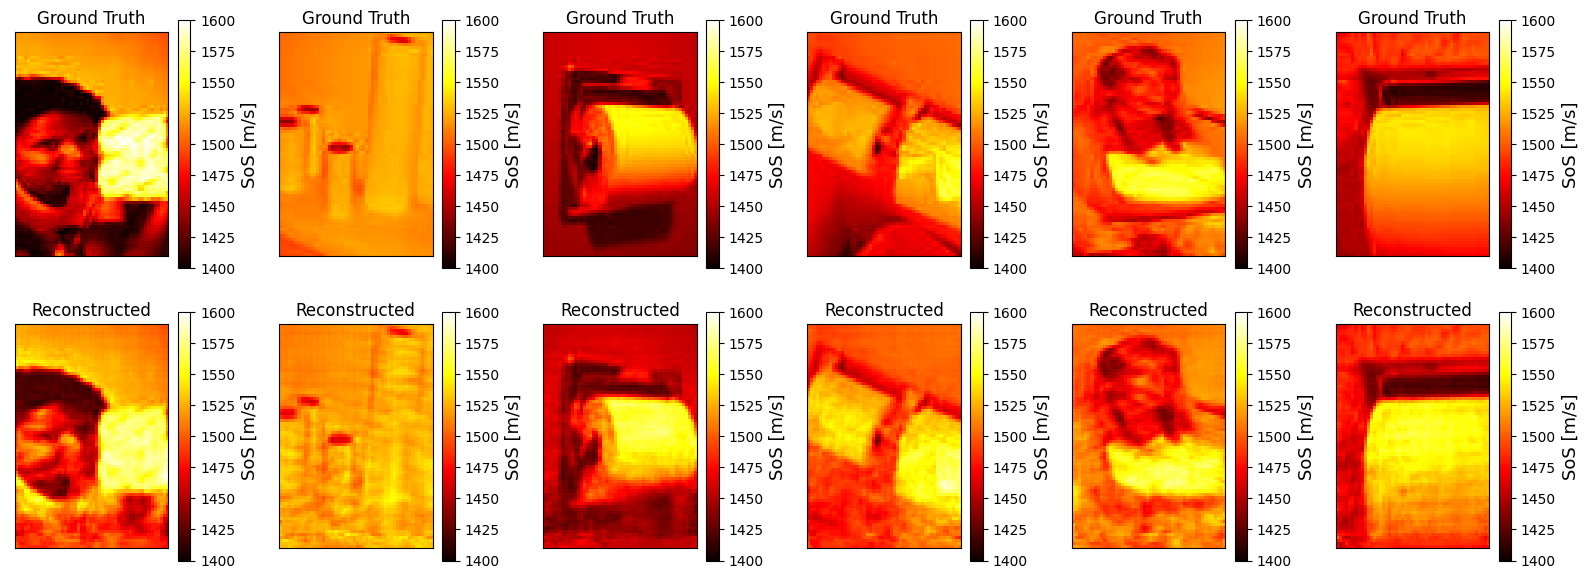

Elapsed time = 97.42872905731201
batch 6001 / 40000
running_loss = 823.9684281925963
batch_loss = 525.40283203125
queue length = 56
RMSE in testing set is 19.133326
Elapsed time = 98.79411959648132
batch 7001 / 40000
running_loss = 785.0640928458569
batch_loss = 565.531005859375
queue length = 336
RMSE in testing set is 18.503836
Elapsed time = 97.65406632423401
batch 8001 / 40000
running_loss = 752.199086966082
batch_loss = 491.4908752441406
queue length = 316
RMSE in testing set is 18.323648
Elapsed time = 96.96690201759338
batch 9001 / 40000
running_loss = 724.4242225957166
batch_loss = 591.3587646484375
queue length = 56
RMSE in testing set is 18.065332
Elapsed time = 98.70142889022827
batch 10001 / 40000
running_loss = 700.1468355071661
batch_loss = 449.8259582519531
queue length = 246
RMSE in testing set is 16.646742


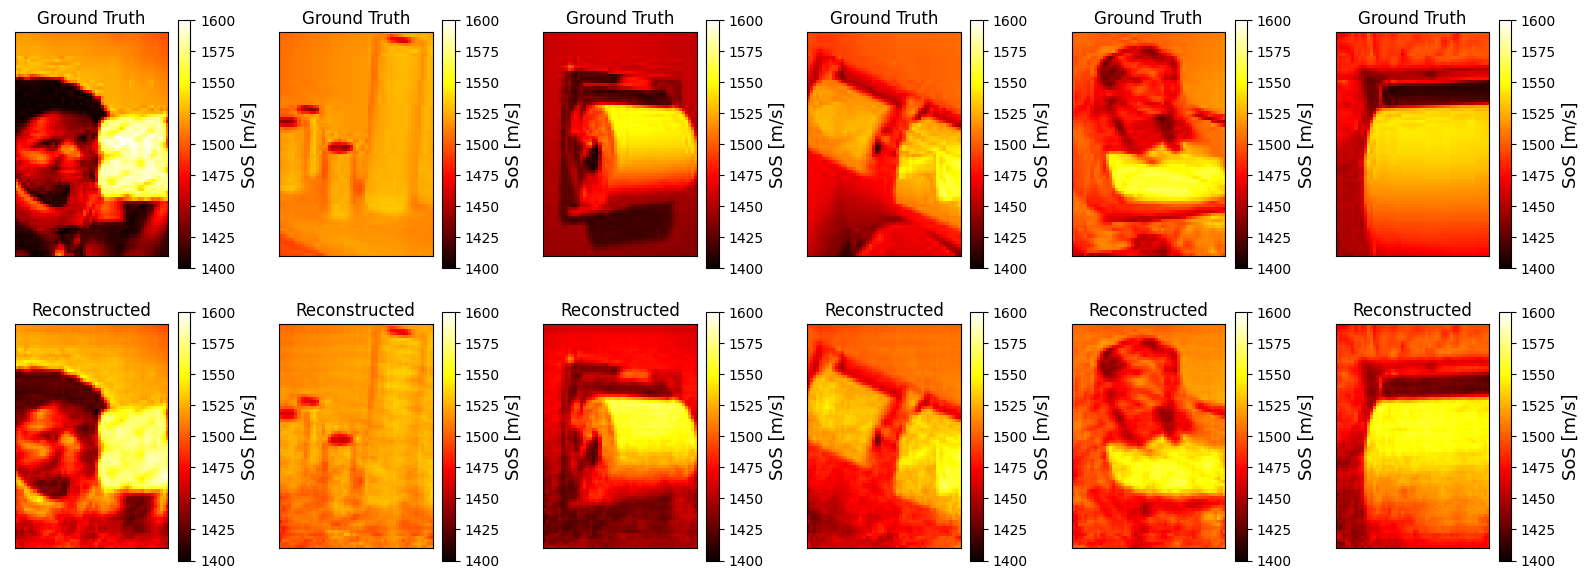

Elapsed time = 98.0356776714325
batch 11001 / 40000
running_loss = 678.541610212938
batch_loss = 389.77423095703125
queue length = 226
RMSE in testing set is 16.839727
Elapsed time = 97.46835041046143
batch 12001 / 40000
running_loss = 659.0387614383199
batch_loss = 485.7131652832031
queue length = 86
RMSE in testing set is 16.472366
Elapsed time = 98.31785845756531
batch 13001 / 40000
running_loss = 642.106450933912
batch_loss = 451.9710998535156
queue length = 246
RMSE in testing set is 15.801119
Elapsed time = 98.65254259109497
batch 14001 / 40000
running_loss = 626.7288190419122
batch_loss = 426.091796875
queue length = 346
RMSE in testing set is 17.769936
Elapsed time = 97.65605401992798
batch 15001 / 40000
running_loss = 612.5844121438919
batch_loss = 427.7574768066406
queue length = 296
RMSE in testing set is 17.340755


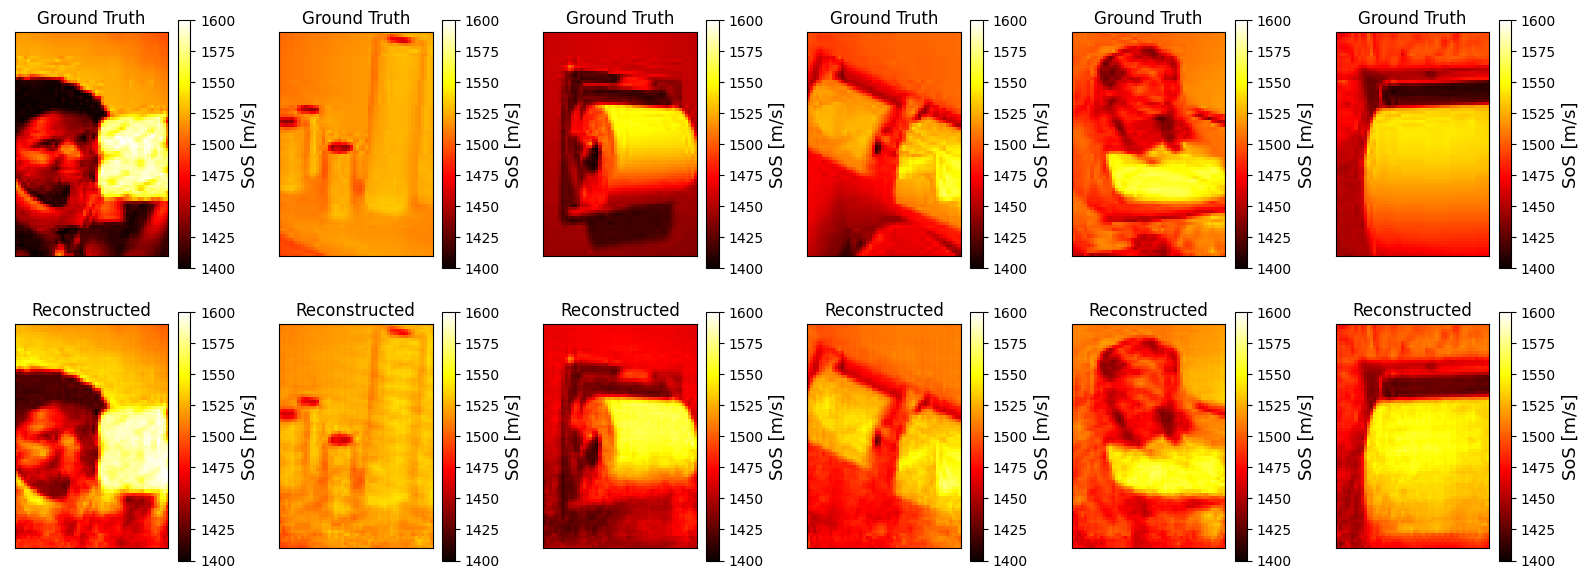

Elapsed time = 97.37232708930969
batch 16001 / 40000
running_loss = 599.8266149977866
batch_loss = 331.4020690917969
queue length = 186
RMSE in testing set is 15.33031
Elapsed time = 97.57566952705383
batch 17001 / 40000
running_loss = 587.9085717321831
batch_loss = 387.3518371582031
queue length = 46
RMSE in testing set is 15.493101
Elapsed time = 98.21250057220459
batch 18001 / 40000
running_loss = 577.0052024231873
batch_loss = 398.550048828125
queue length = 146
RMSE in testing set is 15.18069
Elapsed time = 97.3680100440979
batch 19001 / 40000
running_loss = 566.796552835747
batch_loss = 342.3268737792969
queue length = 96
RMSE in testing set is 14.309405
Elapsed time = 98.01748394966125
batch 20001 / 40000
running_loss = 557.3615992480952
batch_loss = 348.01385498046875
queue length = 196
RMSE in testing set is 14.129983


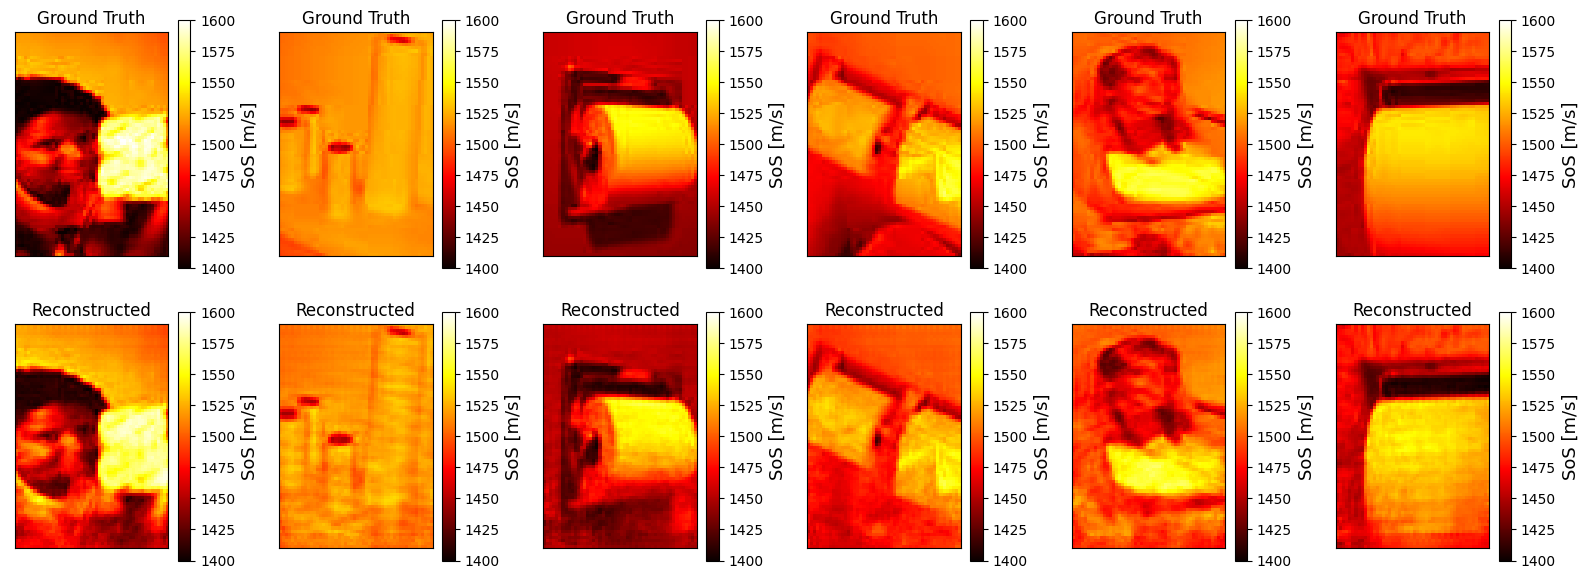

Elapsed time = 97.85283327102661
batch 21001 / 40000
running_loss = 548.7999202044234
batch_loss = 347.39324951171875
queue length = 296
RMSE in testing set is 15.75713
Elapsed time = 97.20406985282898
batch 22001 / 40000
running_loss = 540.5706772954667
batch_loss = 380.24859619140625
queue length = 36
RMSE in testing set is 14.492214
Elapsed time = 83.6432876586914
batch 23001 / 40000
running_loss = 532.9895025375522
batch_loss = 305.4818115234375
queue length = 76
RMSE in testing set is 14.217626
Elapsed time = 77.44430828094482
batch 24001 / 40000
running_loss = 525.9036849347485
batch_loss = 378.36578369140625
queue length = 296
RMSE in testing set is 13.827629
Elapsed time = 78.1221878528595
batch 25001 / 40000
running_loss = 519.2230464507176
batch_loss = 392.737548828125
queue length = 366
RMSE in testing set is 14.488797


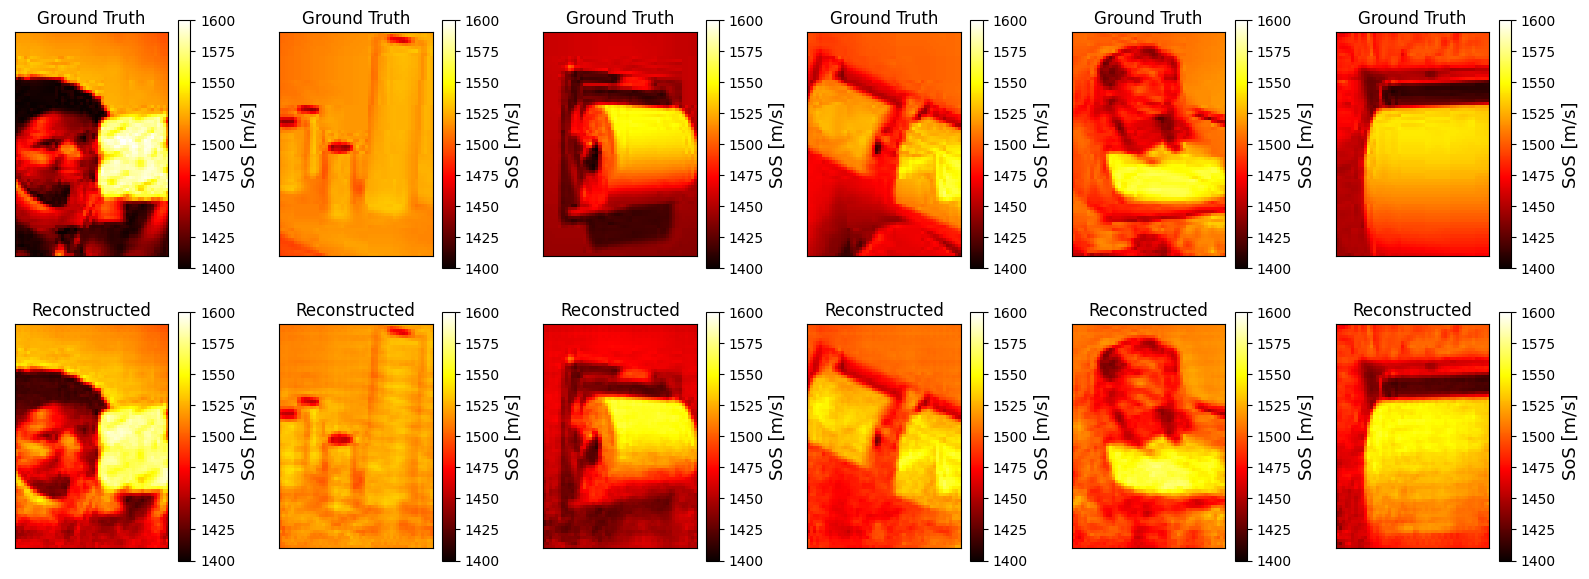

Elapsed time = 75.1946930885315
batch 26001 / 40000
running_loss = 512.7875549132141
batch_loss = 359.5372314453125
queue length = 76
RMSE in testing set is 13.244657
Elapsed time = 79.4647376537323
batch 27001 / 40000
running_loss = 506.8062536913363
batch_loss = 388.8245544433594
queue length = 386
RMSE in testing set is 14.070337
Elapsed time = 75.36398768424988
batch 28001 / 40000
running_loss = 501.101130341472
batch_loss = 410.5546569824219
queue length = 186
RMSE in testing set is 13.218343
Elapsed time = 76.62469148635864
batch 29001 / 40000
running_loss = 495.68016633934155
batch_loss = 362.333740234375
queue length = 526
RMSE in testing set is 14.180241
Elapsed time = 74.51735877990723
batch 30001 / 40000
running_loss = 490.4329039624084
batch_loss = 314.81927490234375
queue length = 236
RMSE in testing set is 13.781846


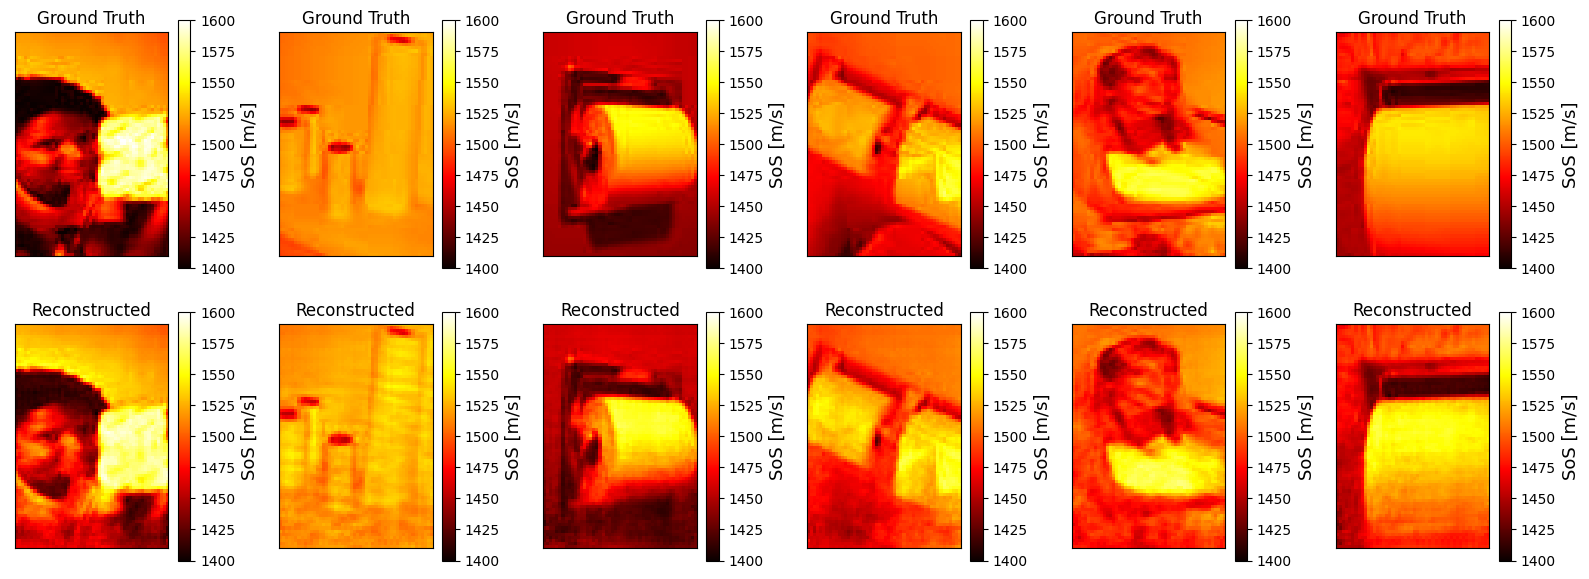

Elapsed time = 75.93051362037659
batch 31001 / 40000
running_loss = 485.4273370888362
batch_loss = 334.8406677246094
queue length = 156
RMSE in testing set is 12.905937
Elapsed time = 76.19487190246582
batch 32001 / 40000
running_loss = 480.6143035435705
batch_loss = 370.5697326660156
queue length = 136
RMSE in testing set is 13.76116
Elapsed time = 77.51067328453064
batch 33001 / 40000
running_loss = 476.0346786242876
batch_loss = 301.768798828125
queue length = 446
RMSE in testing set is 17.19839
Elapsed time = 75.70974922180176
batch 34001 / 40000
running_loss = 471.62182203294753
batch_loss = 289.11383056640625
queue length = 336
RMSE in testing set is 12.453542
Elapsed time = 76.2320466041565
batch 35001 / 40000
running_loss = 467.3832772544136
batch_loss = 354.9219970703125
queue length = 196
RMSE in testing set is 13.359749


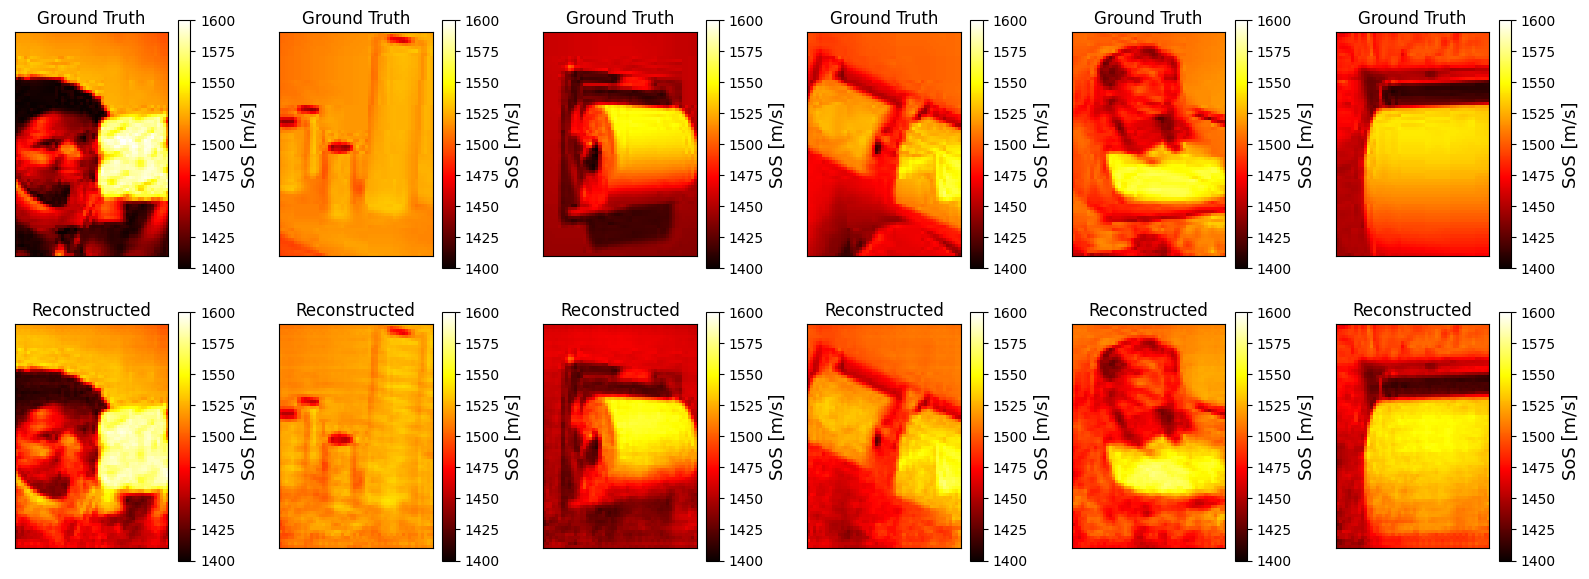

Elapsed time = 76.626549243927
batch 36001 / 40000
running_loss = 463.45237256309656
batch_loss = 260.1038818359375
queue length = 116
RMSE in testing set is 14.2862
Elapsed time = 75.15994501113892
batch 37001 / 40000
running_loss = 459.63466029102483
batch_loss = 305.78106689453125
queue length = 336
RMSE in testing set is 13.238698
Elapsed time = 76.71985936164856
batch 38001 / 40000
running_loss = 456.01203269992624
batch_loss = 298.7471618652344
queue length = 106
RMSE in testing set is 12.389638
Elapsed time = 78.74270033836365
batch 39001 / 40000
running_loss = 452.4481287575228
batch_loss = 320.35357666015625
queue length = 356
RMSE in testing set is 13.433372
Epoch 1/3 finished. Average loss: 449.0139503742218
Elapsed time = 78.36168336868286
batch 1 / 40000
running_loss = 338.2329559326172
batch_loss = 387.8807067871094
queue length = 206
RMSE in testing set is 12.674792


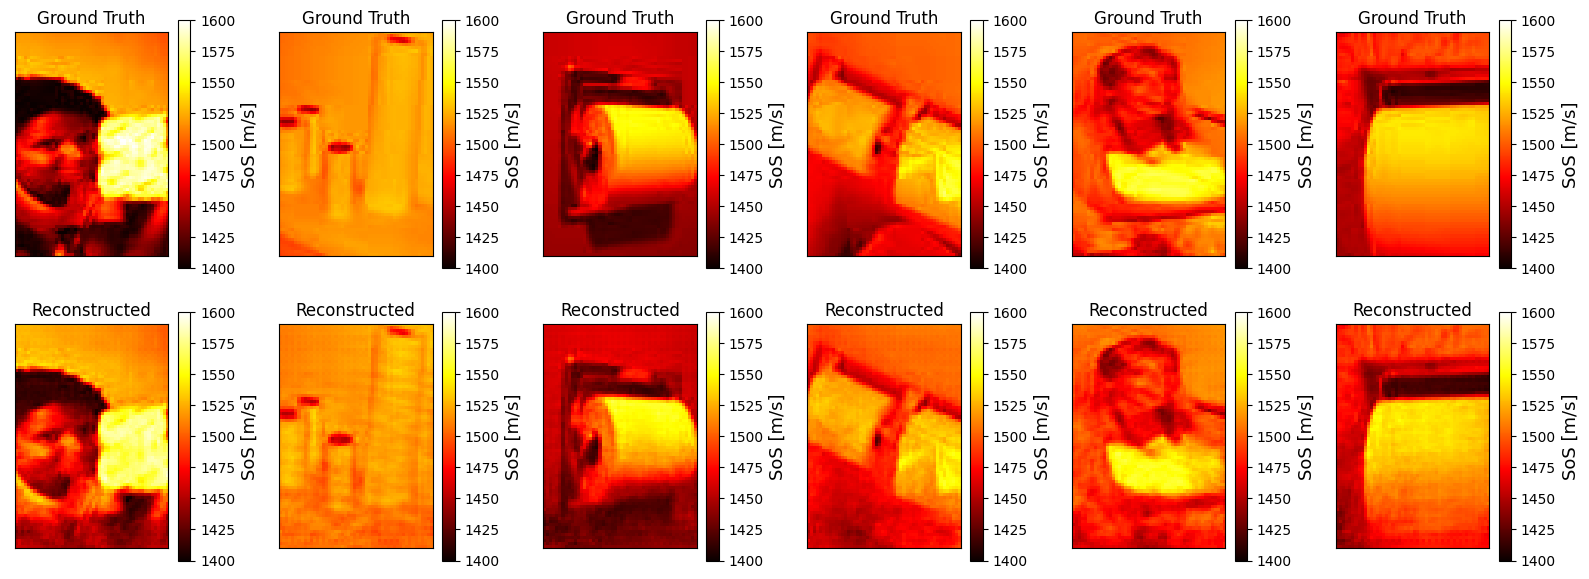

Elapsed time = 75.47666549682617
batch 1001 / 40000
running_loss = 309.7171559438496
batch_loss = 270.7811279296875
queue length = 156
RMSE in testing set is 13.161568
Elapsed time = 76.72943305969238
batch 2001 / 40000
running_loss = 310.345090174413
batch_loss = 300.33056640625
queue length = 406
RMSE in testing set is 12.825976
Elapsed time = 76.65102887153625
batch 3001 / 40000
running_loss = 310.5517379333781
batch_loss = 305.28729248046875
queue length = 326
RMSE in testing set is 12.815422
Elapsed time = 76.93022751808167
batch 4001 / 40000
running_loss = 311.01215288199404
batch_loss = 341.4812927246094
queue length = 216
RMSE in testing set is 14.74428
Elapsed time = 73.4718279838562
batch 5001 / 40000
running_loss = 310.0566937501123
batch_loss = 313.2351989746094
queue length = 196
RMSE in testing set is 16.75305


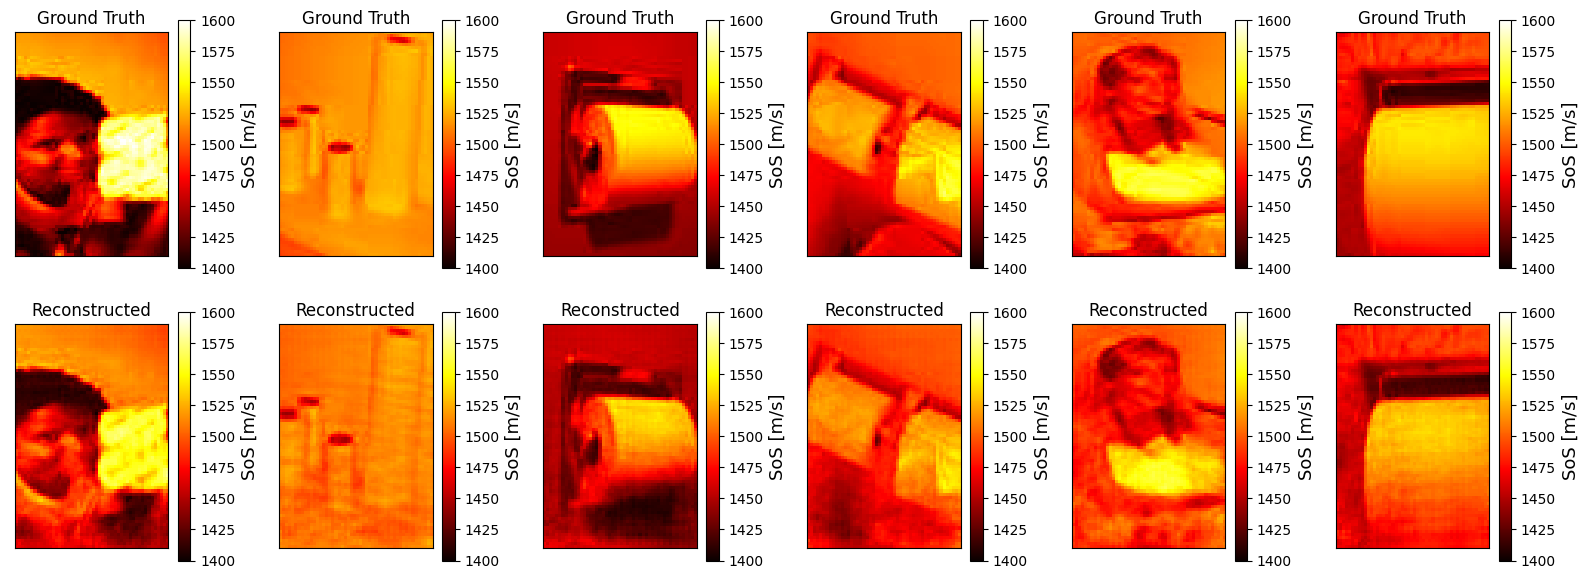

Elapsed time = 76.69204211235046
batch 6001 / 40000
running_loss = 308.78088134592747
batch_loss = 350.5611572265625
queue length = 506
RMSE in testing set is 13.69612
Elapsed time = 75.85244631767273
batch 7001 / 40000
running_loss = 307.740279552086
batch_loss = 382.14019775390625
queue length = 36
RMSE in testing set is 16.0803
Elapsed time = 77.4064073562622
batch 8001 / 40000
running_loss = 307.56205503715927
batch_loss = 264.2142028808594
queue length = 166
RMSE in testing set is 12.610863
Elapsed time = 76.50055313110352
batch 9001 / 40000
running_loss = 307.04349827506866
batch_loss = 408.3906555175781
queue length = 266
RMSE in testing set is 11.607177
Elapsed time = 74.79432439804077
batch 10001 / 40000
running_loss = 306.3846654115832
batch_loss = 241.39248657226562
queue length = 366
RMSE in testing set is 11.428866


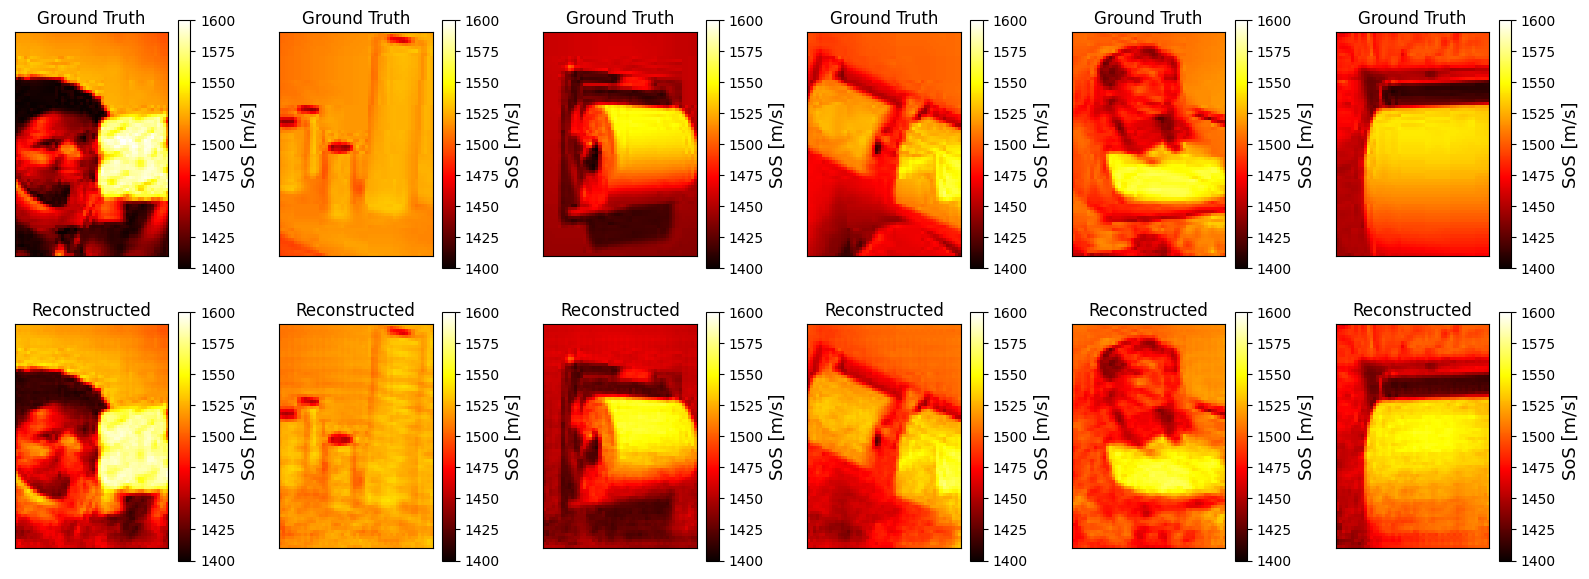

Elapsed time = 77.60455179214478
batch 11001 / 40000
running_loss = 305.77895858811803
batch_loss = 317.1860656738281
queue length = 376
RMSE in testing set is 17.551151
Elapsed time = 76.35168695449829
batch 12001 / 40000
running_loss = 305.33102712454826
batch_loss = 280.04632568359375
queue length = 386
RMSE in testing set is 12.9373865
Elapsed time = 77.38282322883606
batch 13001 / 40000
running_loss = 304.7866793991767
batch_loss = 301.5928955078125
queue length = 396
RMSE in testing set is 13.547856
Elapsed time = 75.67598223686218
batch 14001 / 40000
running_loss = 304.03568850188844
batch_loss = 327.6794128417969
queue length = 406
RMSE in testing set is 12.250803
Elapsed time = 76.2006504535675
batch 15001 / 40000
running_loss = 303.0732170199572
batch_loss = 261.44061279296875
queue length = 296
RMSE in testing set is 13.325825


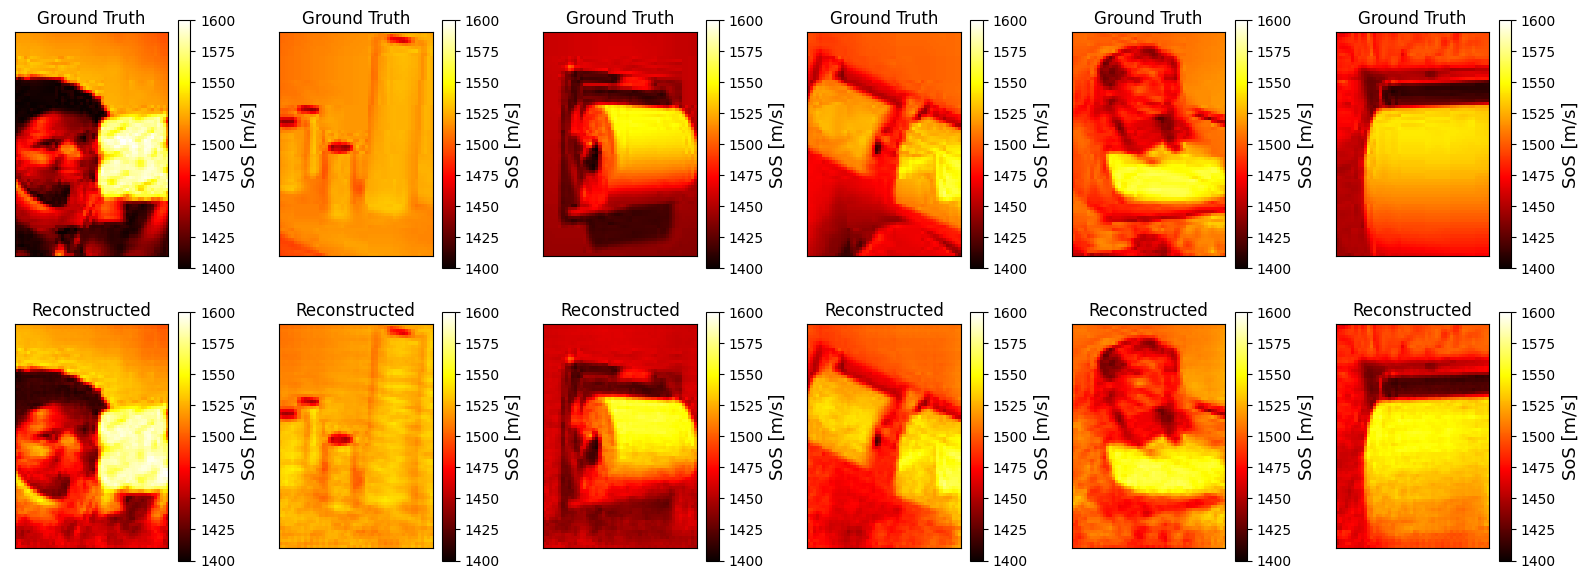

Elapsed time = 76.36194443702698
batch 16001 / 40000
running_loss = 302.6454941842902
batch_loss = 218.339599609375
queue length = 156
RMSE in testing set is 11.254658
Elapsed time = 76.25477838516235
batch 17001 / 40000
running_loss = 301.97230438063696
batch_loss = 274.7237854003906
queue length = 316
RMSE in testing set is 15.432237
Elapsed time = 75.85607361793518
batch 18001 / 40000
running_loss = 301.2799453718399
batch_loss = 307.9117431640625
queue length = 236
RMSE in testing set is 13.073433
Elapsed time = 75.02386021614075
batch 19001 / 40000
running_loss = 300.751854687261
batch_loss = 272.4078369140625
queue length = 96
RMSE in testing set is 12.917468
Elapsed time = 76.5799252986908
batch 20001 / 40000
running_loss = 300.1564359707828
batch_loss = 303.4515686035156
queue length = 226
RMSE in testing set is 12.954556


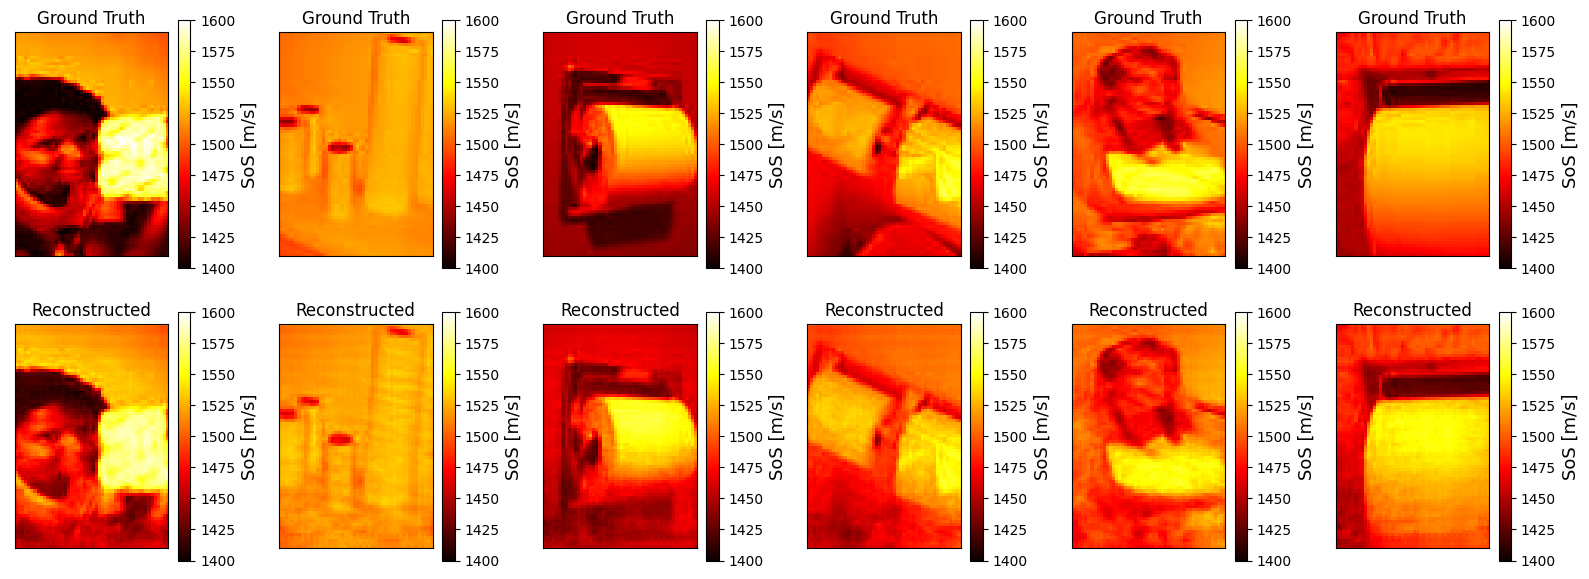

Elapsed time = 76.81597805023193
batch 21001 / 40000
running_loss = 299.7809425842965
batch_loss = 275.47296142578125
queue length = 446
RMSE in testing set is 11.793576
Elapsed time = 75.04155707359314
batch 22001 / 40000
running_loss = 299.1524834599498
batch_loss = 274.424072265625
queue length = 456
RMSE in testing set is 13.352438
Elapsed time = 75.58373475074768
batch 23001 / 40000
running_loss = 298.6918613343288
batch_loss = 264.6670837402344
queue length = 376
RMSE in testing set is 10.872509
Elapsed time = 73.51736497879028
batch 24001 / 40000
running_loss = 298.17538519853673
batch_loss = 245.6534423828125
queue length = 206
RMSE in testing set is 11.652281
Elapsed time = 75.59788727760315
batch 25001 / 40000
running_loss = 297.69085905500606
batch_loss = 308.655517578125
queue length = 246
RMSE in testing set is 13.272617


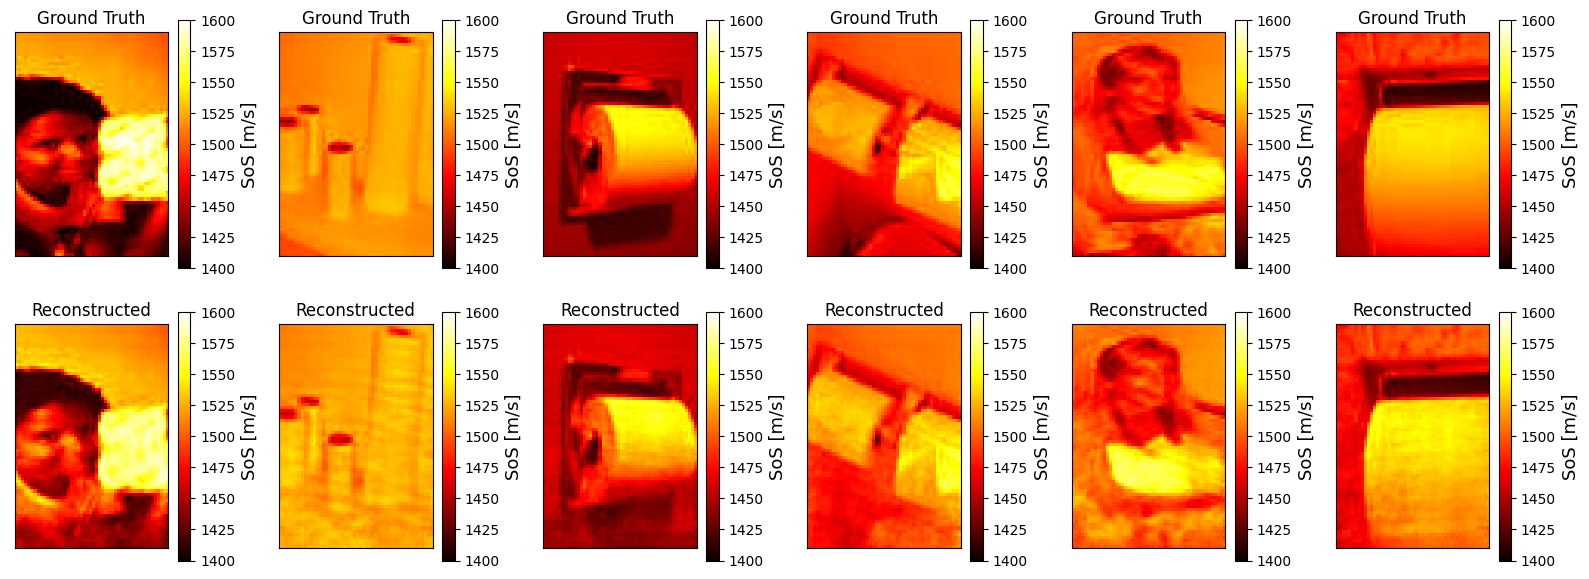

Elapsed time = 75.06571817398071
batch 26001 / 40000
running_loss = 297.2627765886436
batch_loss = 260.1980895996094
queue length = 166
RMSE in testing set is 11.740624
Elapsed time = 75.29768824577332
batch 27001 / 40000
running_loss = 296.7470946558122
batch_loss = 276.5189208984375
queue length = 446
RMSE in testing set is 11.246685
Elapsed time = 77.83722162246704
batch 28001 / 40000
running_loss = 296.178146897414
batch_loss = 293.9342041015625
queue length = 246
RMSE in testing set is 15.764739
Elapsed time = 76.02087163925171
batch 29001 / 40000
running_loss = 295.772126442136
batch_loss = 305.8012390136719
queue length = 166
RMSE in testing set is 12.473051
Elapsed time = 77.83910822868347
batch 30001 / 40000
running_loss = 295.3169112975069
batch_loss = 330.4391784667969
queue length = 416
RMSE in testing set is 14.470332


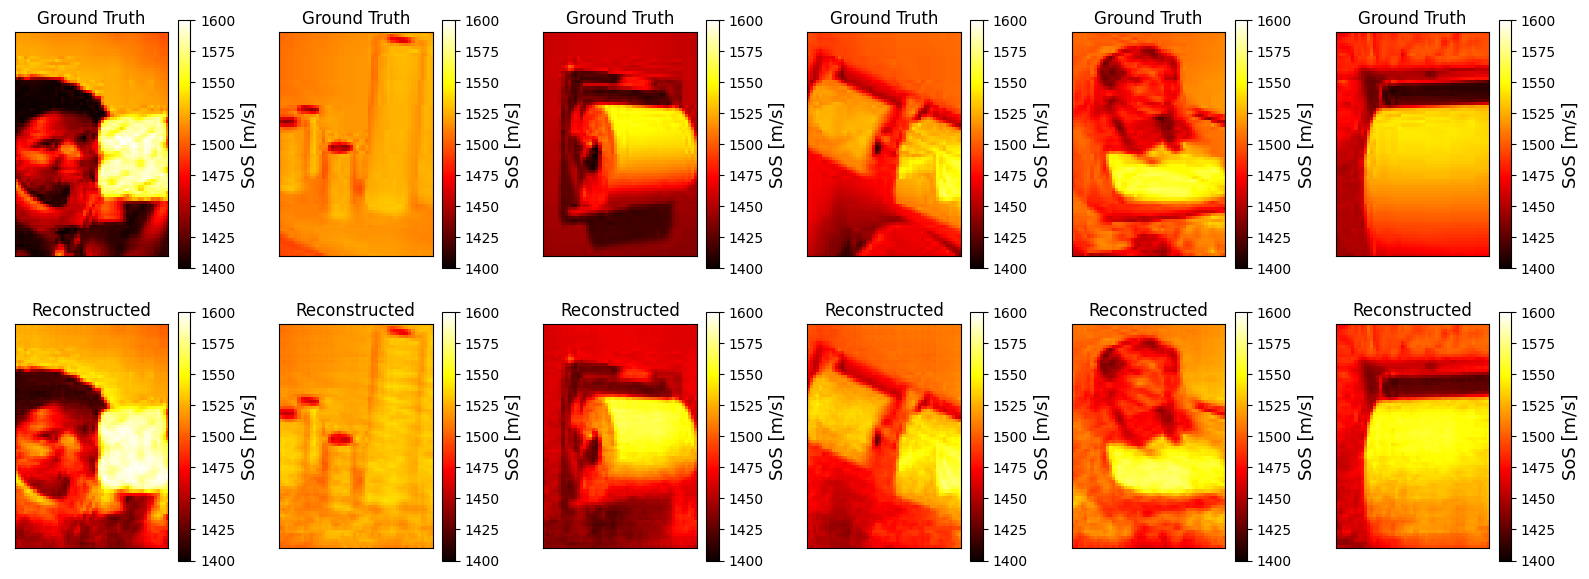

Elapsed time = 74.63993263244629
batch 31001 / 40000
running_loss = 294.95256124134335
batch_loss = 270.4515686035156
queue length = 156
RMSE in testing set is 11.8765135
Elapsed time = 76.35551977157593
batch 33001 / 40000
running_loss = 294.08660839754236
batch_loss = 256.0209045410156
queue length = 116
RMSE in testing set is 15.231604
Elapsed time = 76.97835397720337
batch 34001 / 40000
running_loss = 293.66218625009145
batch_loss = 287.8643493652344
queue length = 486
RMSE in testing set is 12.507318
Elapsed time = 75.62083077430725
batch 35001 / 40000
running_loss = 293.29029642040473
batch_loss = 280.2738037109375
queue length = 136
RMSE in testing set is 14.112425


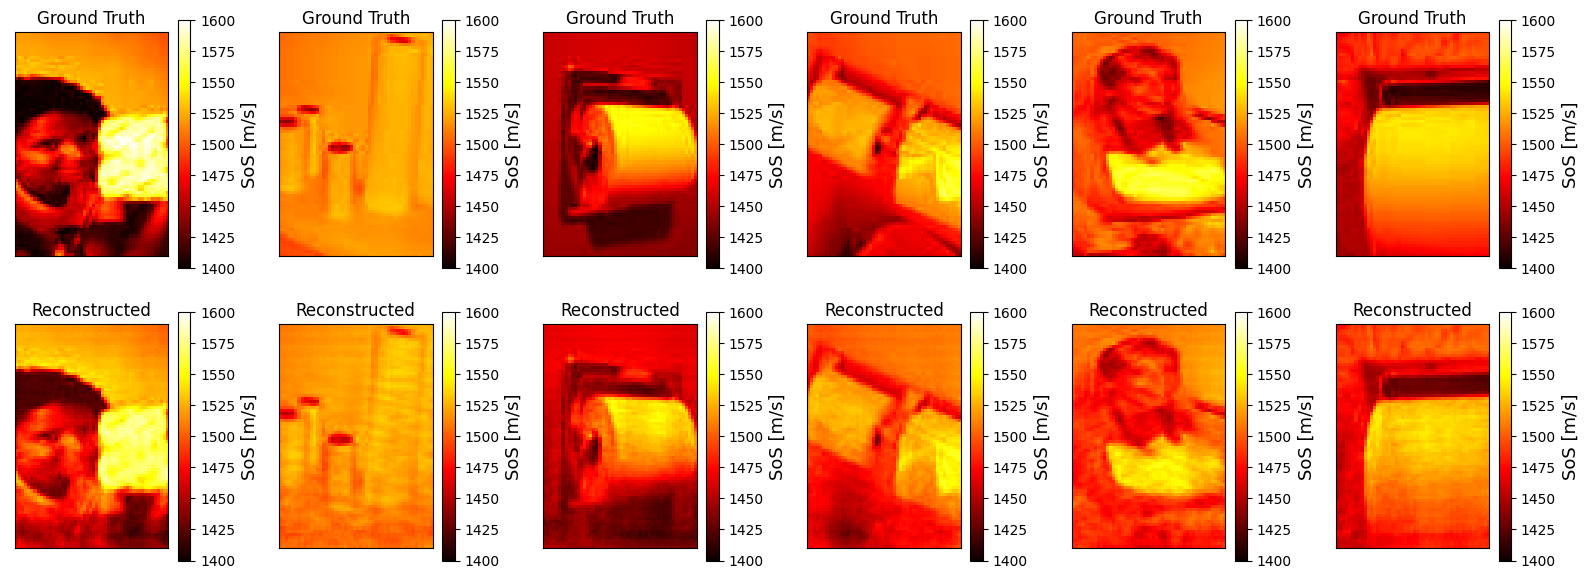

Elapsed time = 77.83707094192505
batch 36001 / 40000
running_loss = 292.78190765033315
batch_loss = 303.7232666015625
queue length = 116
RMSE in testing set is 12.675432
Elapsed time = 78.40229272842407
batch 37001 / 40000
running_loss = 292.37063994308943
batch_loss = 237.33480834960938
queue length = 276
RMSE in testing set is 11.785631
Elapsed time = 76.70299959182739
batch 38001 / 40000
running_loss = 291.9897904567459
batch_loss = 252.0009002685547
queue length = 376
RMSE in testing set is 11.391885
Elapsed time = 76.90952205657959
batch 39001 / 40000
running_loss = 291.554899452882
batch_loss = 274.7732849121094
queue length = 326
RMSE in testing set is 12.313885
Epoch 2/3 finished. Average loss: 291.22664156303404
Elapsed time = 76.51838326454163
batch 1 / 40000
running_loss = 289.98899841308594
batch_loss = 302.7163391113281
queue length = 235
RMSE in testing set is 15.56111


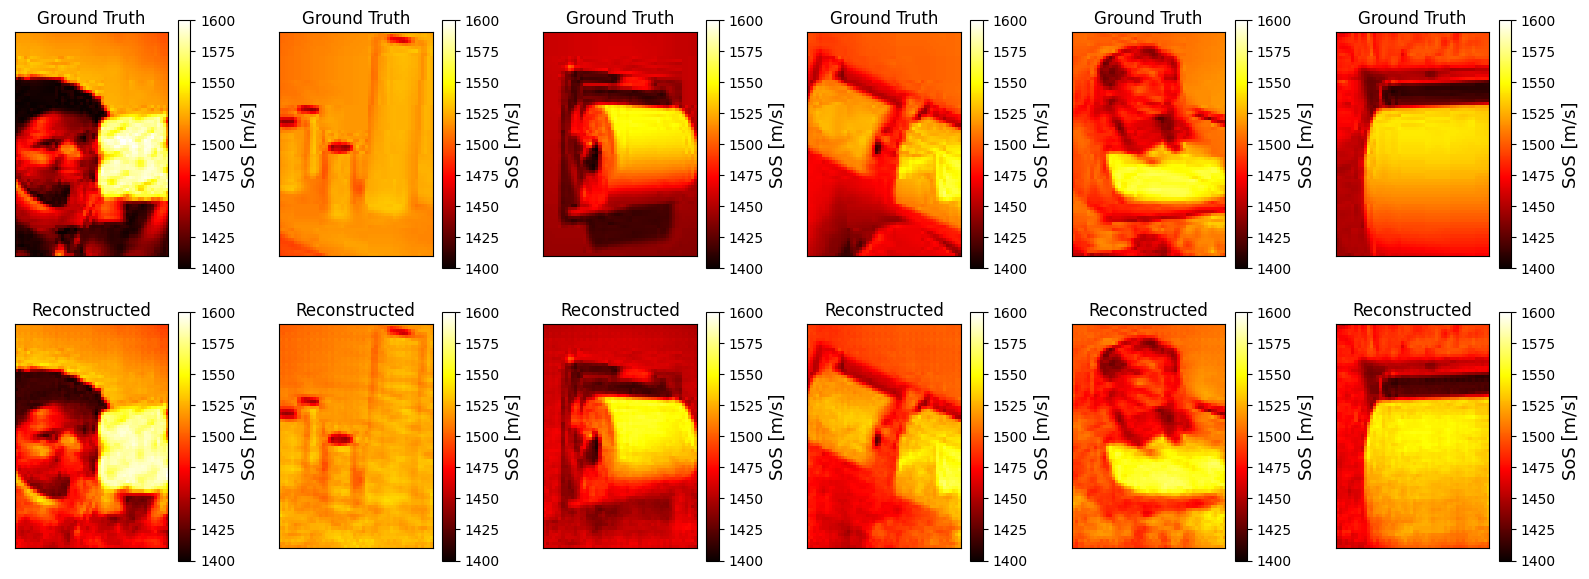

Elapsed time = 76.55662441253662
batch 1001 / 40000
running_loss = 274.2098777908051
batch_loss = 375.22900390625
queue length = 215
RMSE in testing set is 11.017736
Elapsed time = 78.0941469669342
batch 2001 / 40000
running_loss = 274.91904995944
batch_loss = 295.1911315917969
queue length = 405
RMSE in testing set is 15.377361
Elapsed time = 77.82340335845947
batch 3001 / 40000
running_loss = 274.16542045598345
batch_loss = 312.34686279296875
queue length = 445
RMSE in testing set is 17.997293
Elapsed time = 76.26935052871704
batch 4001 / 40000
running_loss = 274.4346786148247
batch_loss = 256.9462585449219
queue length = 485
RMSE in testing set is 13.060339
Elapsed time = 76.37654328346252
batch 5001 / 40000
running_loss = 274.44698879176354
batch_loss = 306.2740783691406
queue length = 705
RMSE in testing set is 12.003472


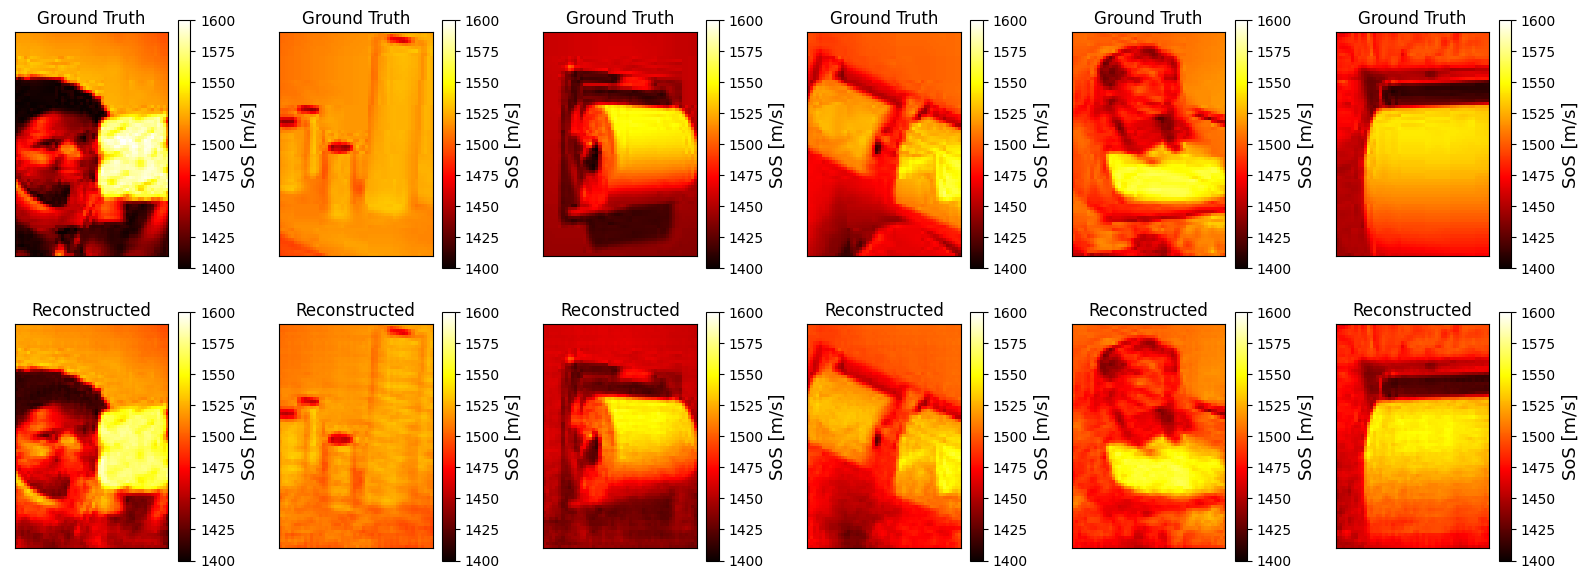

Elapsed time = 75.65712690353394
batch 6001 / 40000
running_loss = 274.5459275924139
batch_loss = 281.1181945800781
queue length = 415
RMSE in testing set is 12.070968
Elapsed time = 74.45197248458862
batch 7001 / 40000
running_loss = 274.10132538730915
batch_loss = 254.8837890625
queue length = 125
RMSE in testing set is 11.787919
Elapsed time = 77.05182409286499
batch 8001 / 40000
running_loss = 273.685653574018
batch_loss = 259.4425964355469
queue length = 435
RMSE in testing set is 13.559858
Elapsed time = 77.01690936088562
batch 9001 / 40000
running_loss = 273.26029106331674
batch_loss = 243.51007080078125
queue length = 175
RMSE in testing set is 12.178841
Elapsed time = 75.57836151123047
batch 10001 / 40000
running_loss = 273.1405814296125
batch_loss = 252.752685546875
queue length = 515
RMSE in testing set is 12.749106


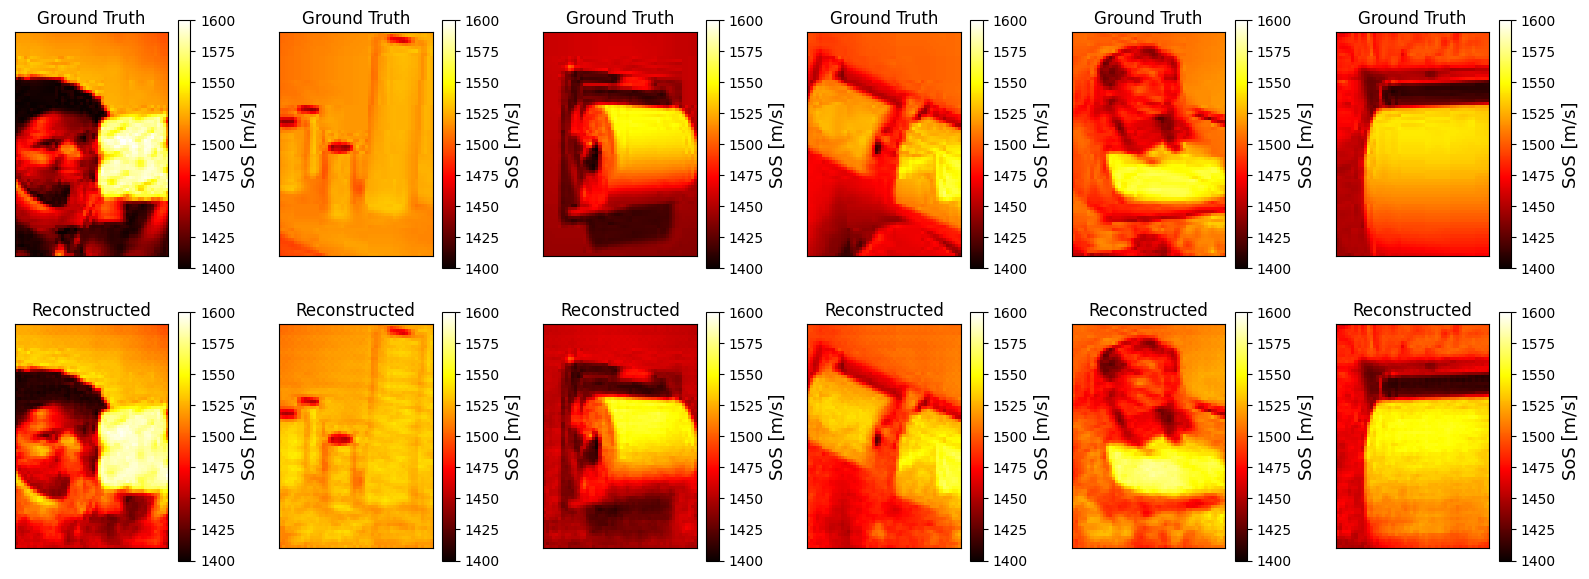

Elapsed time = 74.56898760795593
batch 11001 / 40000
running_loss = 272.86685608664635
batch_loss = 318.93438720703125
queue length = 225
RMSE in testing set is 13.446786
Elapsed time = 74.88212299346924
batch 12001 / 40000
running_loss = 272.45811484142496
batch_loss = 224.8430633544922
queue length = 85
RMSE in testing set is 12.262867
Elapsed time = 74.14513826370239
batch 13001 / 40000
running_loss = 272.21991703565664
batch_loss = 238.82989501953125
queue length = 155
RMSE in testing set is 11.955291
Elapsed time = 75.4075939655304
batch 14001 / 40000
running_loss = 271.7863055096918
batch_loss = 297.30145263671875
queue length = 345
RMSE in testing set is 12.663771
Elapsed time = 75.30884838104248
batch 15001 / 40000
running_loss = 271.4531663295317
batch_loss = 240.29359436035156
queue length = 205
RMSE in testing set is 11.376138


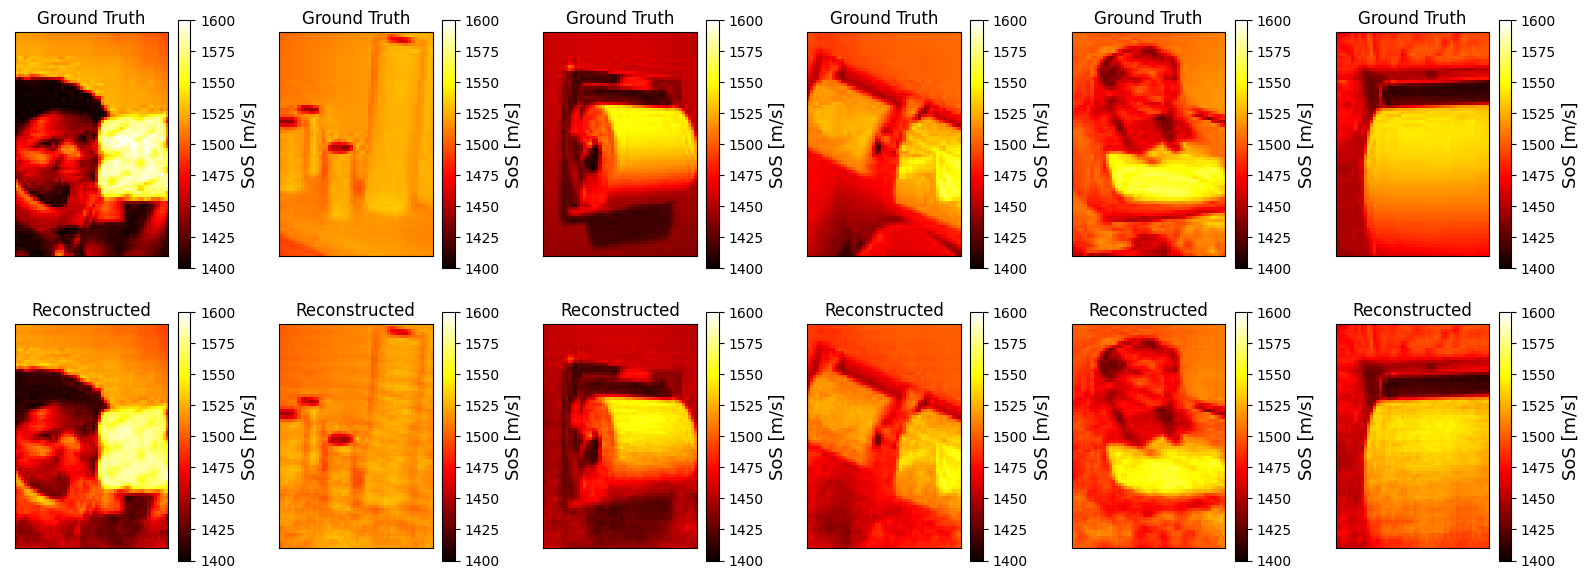

Elapsed time = 76.7690041065216
batch 16001 / 40000
running_loss = 271.1328067672266
batch_loss = 220.23008728027344
queue length = 425
RMSE in testing set is 11.820023
Elapsed time = 77.36784982681274
batch 17001 / 40000
running_loss = 270.8109724939802
batch_loss = 263.1162109375
queue length = 345
RMSE in testing set is 11.674941
Elapsed time = 77.98616933822632
batch 18001 / 40000
running_loss = 270.4047613000886
batch_loss = 266.7631530761719
queue length = 295
RMSE in testing set is 12.805629
Elapsed time = 77.10607171058655
batch 19001 / 40000
running_loss = 270.1740138025086
batch_loss = 292.32220458984375
queue length = 365
RMSE in testing set is 10.896659
Elapsed time = 76.39648675918579
batch 20001 / 40000
running_loss = 269.91899907604454
batch_loss = 253.78707885742188
queue length = 465
RMSE in testing set is 11.613222


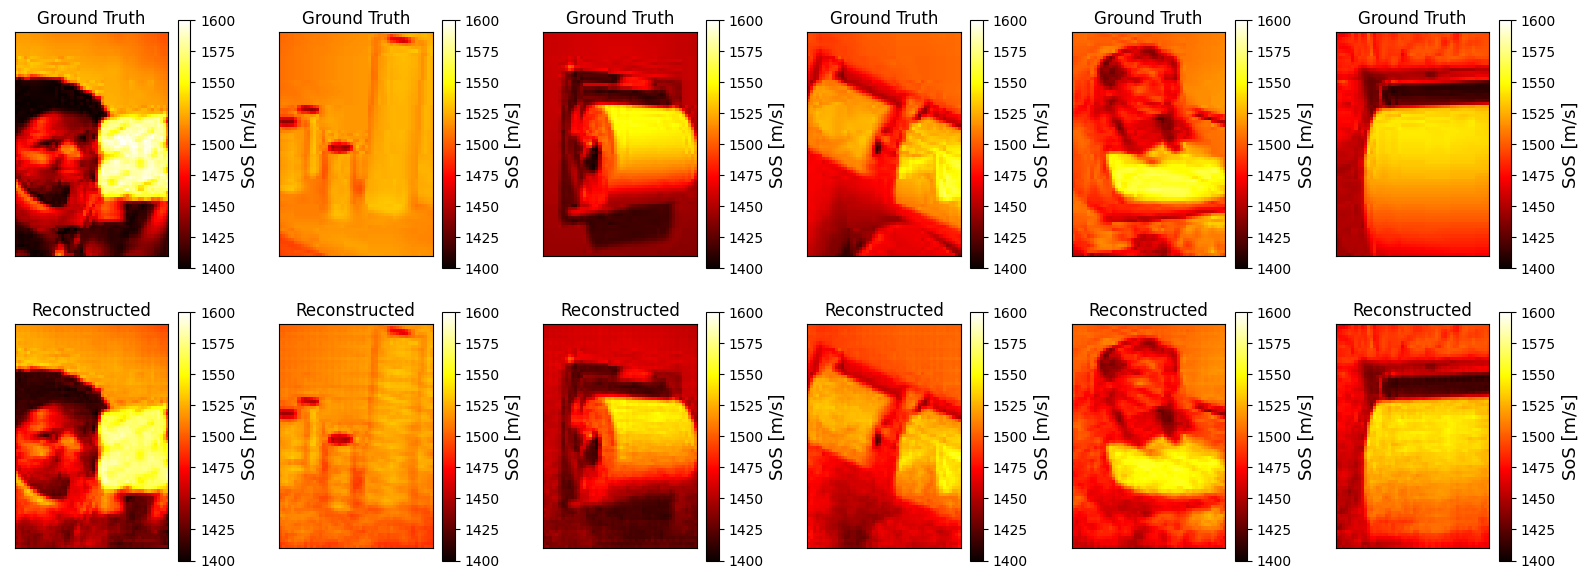

Elapsed time = 77.58875060081482
batch 21001 / 40000
running_loss = 269.5941412474993
batch_loss = 314.16741943359375
queue length = 295
RMSE in testing set is 11.397082
Elapsed time = 76.53739762306213
batch 22001 / 40000
running_loss = 269.3648971878023
batch_loss = 217.64886474609375
queue length = 335
RMSE in testing set is 11.988407
Elapsed time = 79.31745171546936
batch 23001 / 40000
running_loss = 269.1284946262209
batch_loss = 263.3122863769531
queue length = 1485
RMSE in testing set is 12.62528
Elapsed time = 74.51179337501526
batch 24001 / 40000
running_loss = 268.8870676277618
batch_loss = 259.6247863769531
queue length = 385
RMSE in testing set is 11.798302
Elapsed time = 77.18275928497314
batch 25001 / 40000
running_loss = 268.60382507595193
batch_loss = 300.6130065917969
queue length = 455
RMSE in testing set is 11.624643


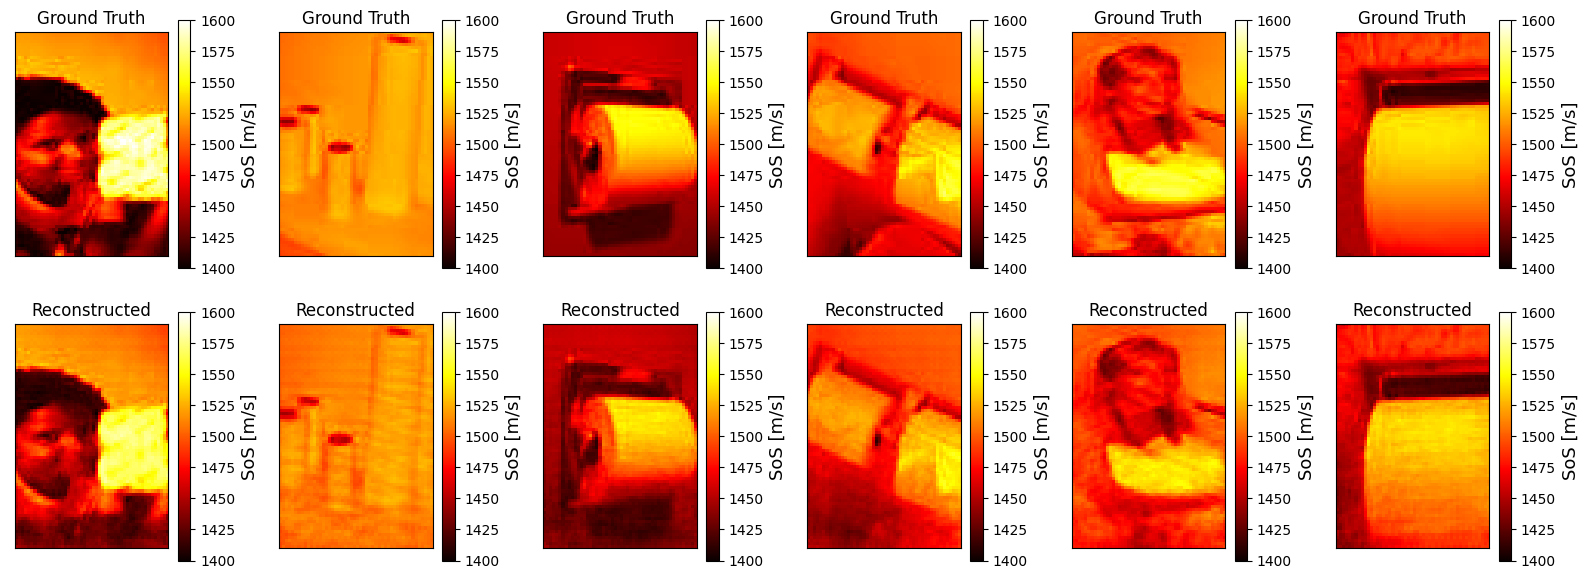

Elapsed time = 77.29549980163574
batch 26001 / 40000
running_loss = 268.4155843403328
batch_loss = 227.00051879882812
queue length = 195
RMSE in testing set is 12.223096
Elapsed time = 75.64575481414795
batch 27001 / 40000
running_loss = 268.12845047773516
batch_loss = 304.8295593261719
queue length = 55
RMSE in testing set is 19.077106
Elapsed time = 76.96341037750244
batch 28001 / 40000
running_loss = 267.79660253618096
batch_loss = 288.39801025390625
queue length = 395
RMSE in testing set is 10.858736
Elapsed time = 77.46157097816467
batch 29001 / 40000
running_loss = 267.6134965329834
batch_loss = 273.62762451171875
queue length = 435
RMSE in testing set is 11.346013
Elapsed time = 76.69386410713196
batch 30001 / 40000
running_loss = 267.3486348494125
batch_loss = 231.26609802246094
queue length = 355
RMSE in testing set is 12.052704


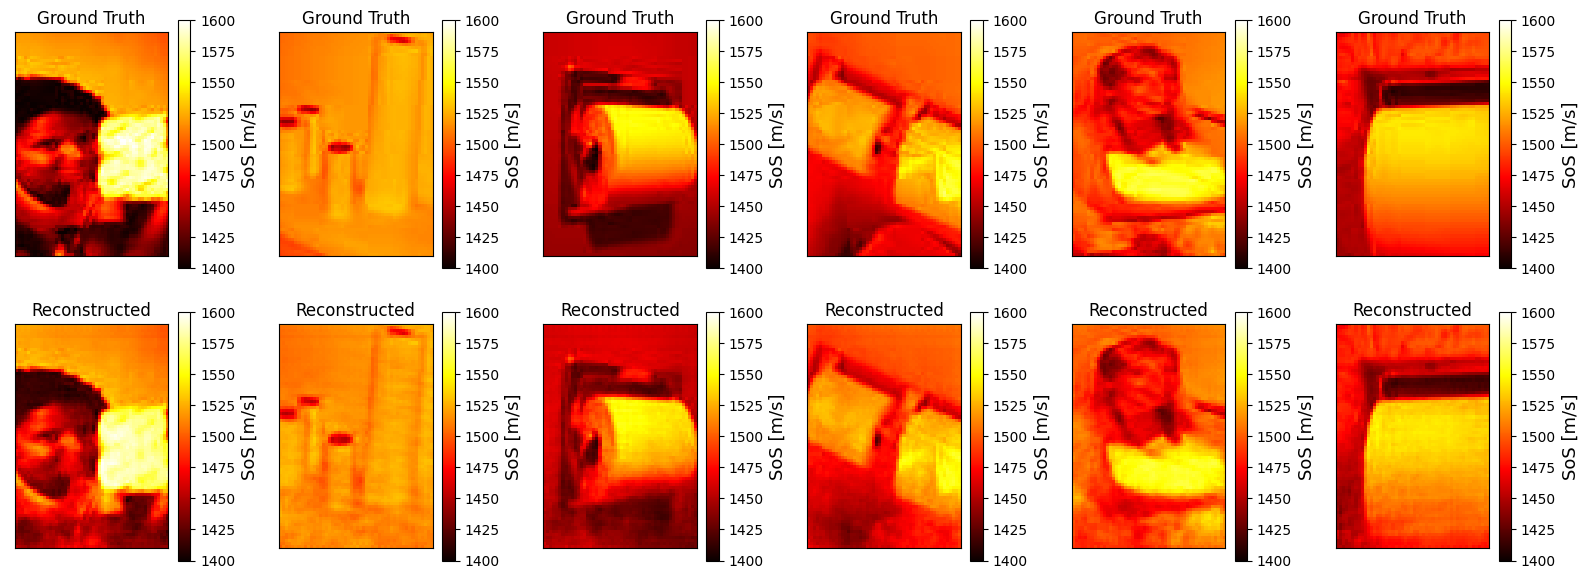

Elapsed time = 76.30199718475342
batch 31001 / 40000
running_loss = 267.131237499822
batch_loss = 282.240966796875
queue length = 65
RMSE in testing set is 13.188673
Elapsed time = 79.54443836212158
batch 32001 / 40000
running_loss = 266.9337406314602
batch_loss = 283.3014831542969
queue length = 555
RMSE in testing set is 11.495387
Elapsed time = 76.26877975463867
batch 33001 / 40000
running_loss = 266.7345467027581
batch_loss = 296.72198486328125
queue length = 295
RMSE in testing set is 11.152213
Elapsed time = 78.49939274787903
batch 34001 / 40000
running_loss = 266.5346673517029
batch_loss = 267.18963623046875
queue length = 275
RMSE in testing set is 11.004086
Elapsed time = 77.27538633346558
batch 35001 / 40000
running_loss = 266.2813372377954
batch_loss = 210.28659057617188
queue length = 465
RMSE in testing set is 11.455397


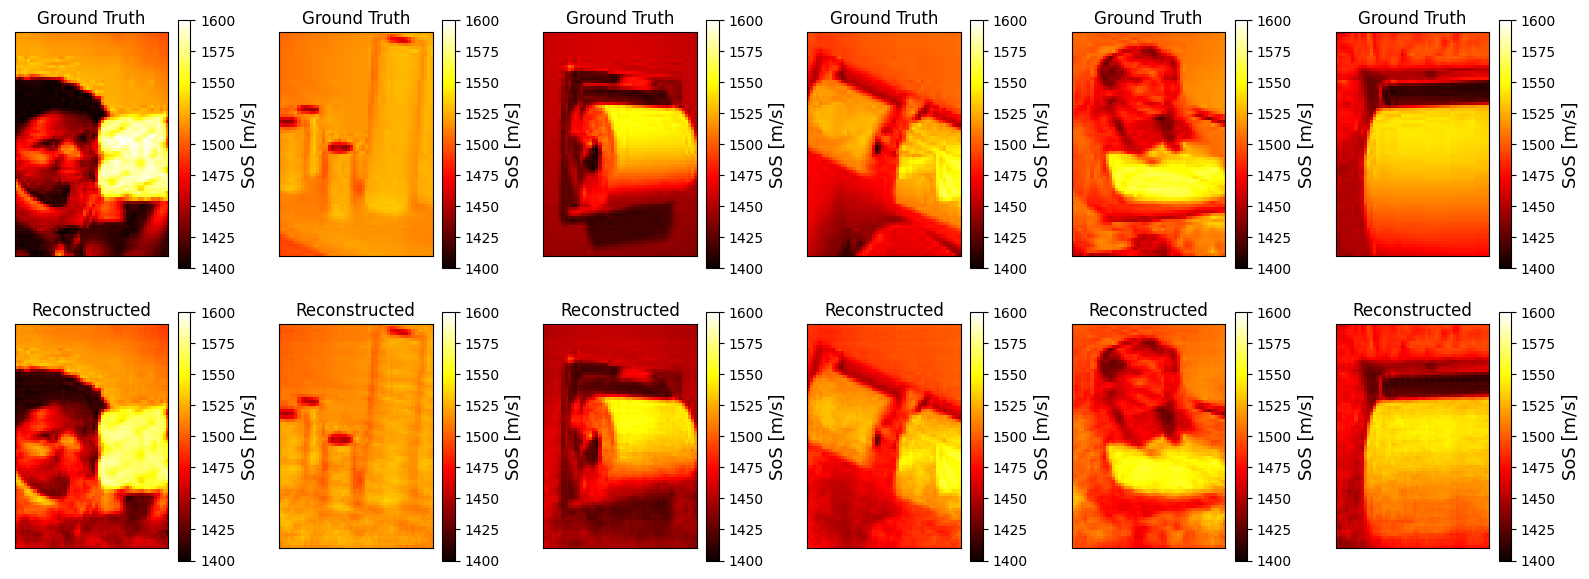

Elapsed time = 80.21922016143799
batch 36001 / 40000
running_loss = 266.1447796526766
batch_loss = 201.46575927734375
queue length = 445
RMSE in testing set is 10.755543
Elapsed time = 76.65947079658508
batch 37001 / 40000
running_loss = 265.9953993447864
batch_loss = 229.25497436523438
queue length = 635
RMSE in testing set is 11.945201
Elapsed time = 75.62922310829163
batch 38001 / 40000
running_loss = 265.8241689033643
batch_loss = 226.74131774902344
queue length = 375
RMSE in testing set is 10.700206
Elapsed time = 76.62603878974915
batch 39001 / 40000
running_loss = 265.6359942427269
batch_loss = 265.44305419921875
queue length = 475
RMSE in testing set is 11.654104
Epoch 3/3 finished. Average loss: 265.4861536758423


In [12]:
model = build_net().to(f"cuda:{GPU_BASE}")
model = nn.DataParallel(model, device_ids=GPU_LIST_TO_PARALLEL)
model.train()

criterion = nn.MSELoss()
SSIM_LOSS = pytorch_SSIM_module.SSIM()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAM_LEARNING_RATE, weight_decay=PARAM_WEIGHTDECAY)

manager = mp.Manager()
shared_queue_time_lag = manager.list()
shared_lock_1, shared_lock_2 = mp.Lock(), mp.Lock()
idx_list_init = list(range(PARAM_NUMBER_OF_TRAINING_DATA))
random.shuffle(idx_list_init)
img_idx_tobe_loaded = manager.list(idx_list_init)


processes = [
    mp.Process(
        target=preparing_training_data,
        args=(
            shared_lock_1,
            shared_lock_2,
            img_idx_tobe_loaded,
            shared_queue_time_lag,
            PARAM_NUMBER_OF_TRAINING_DATA,
            4000,
            data_parent_dir,  # <--- Pass the data dir to the worker
        ),
    )
    for _ in range(3)
]
for p in processes:
    p.start()
    sleep(1)

LEN_TRAINING_DATA = PARAM_NUMBER_OF_TRAINING_DATA
last_time_stamp = time.time()
for epoch_i in range(EPOCH_NUM):
    running_loss = 0.0
    for batch_i in range(LEN_TRAINING_DATA // BATCH_SIZE):
        batch_data_np, batch_label_np = [], []
        for _ in range(BATCH_SIZE):
            while len(shared_queue_time_lag) == 0:
                sleep(1)
            time_lag_np, sos_np = shared_queue_time_lag.pop()
            batch_data_np.append(time_lag_np * PARAM_SCALING_INPUT)
            batch_label_np.append(sos_np)

        batch_data = torch.from_numpy(np.stack(batch_data_np)).to(f"cuda:{GPU_BASE}", dtype=torch.float)
        batch_label = torch.from_numpy(np.stack(batch_label_np)).unsqueeze(1).to(f"cuda:{GPU_BASE}", dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss_MSE = criterion(
            outputs[:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL] * PARAM_SCALING_OUTPUT + PARAM_BASE_OUTPUT,
            batch_label[:, :, :, STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL],
        )
        
        loss_SSIM = -SSIM_LOSS((outputs[:,:,:,STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL]-1400)/200,
                                       (batch_label[:,:,:,STARTING_PIXEL:STARTING_PIXEL+WIDTH_IN_PIXEL]-1400)/200)
        loss = loss_MSE + 5000*loss_SSIM
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_i % 1000 == 1:
            print("Elapsed time =", time.time() - last_time_stamp)
            last_time_stamp = time.time()
            print(f"batch {batch_i} / {LEN_TRAINING_DATA // BATCH_SIZE}")
            print("running_loss =", running_loss / (batch_i + 1))
            print("batch_loss =", loss.item())
            print("queue length =", len(shared_queue_time_lag))

            from datetime import datetime
            current_date = datetime.now().strftime("%Y_%m_%d")
            ckpt_name = (
                f"./pre_trained_model_d{current_date}_parametric_3_input_beamforming_SoS_"
                f"{PARAM_SOS_BEAMFORMING}_output_base_{PARAM_BASE_OUTPUT}_NumberOfTraningData_"
                f"{PARAM_NUMBER_OF_TRAINING_DATA}_learning_rate_{PARAM_LEARNING_RATE}_"
                f"PARAM_WEIGHTDECAY_{PARAM_WEIGHTDECAY}_no_batch_norm.pt"
            )
            torch.save(model.module.state_dict(), ckpt_name)
            model.eval()
            eval_testingdata(model, test_data, test_label, criterion)
            if batch_i % 5000 == 1:
                visualize_test_data()
            model.train()

    print(f"Epoch {epoch_i + 1}/{EPOCH_NUM} finished. "
          f"Average loss: {running_loss / (LEN_TRAINING_DATA / BATCH_SIZE)}")
